Starting with a tree sequence generated by a SLiM simulation. I first simplify the tree sequence to only show the relationships between a subset of samples. Working with a networkx graph makes the following simplification steps easier.

In [700]:
import msprime
import tskit
import numpy as np
import networkx as nx
from collections import defaultdict
from itertools import chain
import pandas as pd
import matplotlib.pyplot as plt


def ts_to_nx(ts, fully_connected=False, connect_recombination_nodes=False, recomb_nodes=[]):
    """Converts tskit tree sequence to networkx graph.
    """
    topology = defaultdict(list)
    if fully_connected:
        for edge in ts.tables.edges:
            topology[edge.parent].append(edge.child)
    else:
        for tree in ts.trees():
            for k, v in chain(tree.parent_dict.items()):
                if connect_recombination_nodes:
                    if recomb_nodes == []:
                        recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
                    if v in recomb_nodes and recomb_nodes.index(v)%2 == 1:
                        v -= 1
                    if k in recomb_nodes and recomb_nodes.index(k)%2 == 1:
                        k -= 1
                    if v not in topology[k]:
                        topology[k].append(v)
                else:
                    if v not in topology[k]:
                        topology[k].append(v)
    nx_graph = nx.MultiDiGraph(topology)
    return nx_graph

ts = tskit.load("run1/slim_0.25rep0sigma.trees")
np.random.seed(1)
keep_nodes = list(np.random.choice(ts.samples(), 50, replace=False))
subset_ts = ts.simplify(samples=keep_nodes, keep_input_roots=True, keep_unary=True)
nx_arg = ts_to_nx(ts=subset_ts, fully_connected=True)

Critical nodes are nodes which affect the topology of the sample. These need to be kept during the simplification process.

In [701]:
def identify_critical_nodes(ts):
    critical_nodes = []
    for node in ts.nodes():
        is_parent = ts.tables.edges[np.where(ts.tables.edges.parent==node.id)[0]]
        is_child = ts.tables.edges[np.where(ts.tables.edges.child==node.id)[0]]
        if (len(np.unique(is_parent.child)) != len(np.unique(is_child.parent))) or (sorted(is_parent.left) != sorted(is_child.left)) or (sorted(is_parent.right) != sorted(is_child.right)):
            critical_nodes.append(node.id)
    return critical_nodes

critical_nodes = identify_critical_nodes(ts=subset_ts)

Simplify the networkx graph to only keep nodes that are critical.

In [702]:
def simplify_graph(G, keep):
    """Loop over the graph until all nodes not in keep list have been removed and their incident edges fused 
    Adapted from https://stackoverflow.com/questions/53353335/networkx-remove-node-and-reconnect-edges
    """
    g = G.copy()
    while any((node not in keep) for node in g.nodes):
        g0 = g.copy() #<- simply changing g itself would cause error `dictionary changed size during iteration` 
        for node in g.nodes:
            if node not in keep:
                in_list = list(g0.in_edges(node))
                out_list = list(g0.out_edges(node))
                previously_found = []
                for in_edge in in_list:
                    a0,b0 = in_edge
                    for out_edge in out_list:
                        if (out_edge not in previously_found) and (out_edge[0] == b0):
                            a1,b1 = out_edge
                            previously_found.append(out_edge)
                            break
                    e0 = a0 if a0!=node else b0
                    e1 = a1 if a1!=node else b1
                    g0.add_edge(e0, e1)
                g0.remove_node(node)
        g = g0
    return g

simple_arg = simplify_graph(G=nx_arg, keep=critical_nodes)

Recombination nodes are nodes that have more than one unique parent and change the left/right ranges.

In [703]:
def identify_recombination_nodes(ts, nodes=[]):
    recomb_nodes = []
    if len(nodes) == 0:
        nodes = range(len(ts.nodes()))
    for i in nodes:
        is_parent = ts.tables.edges[np.where(ts.tables.edges.parent==i)[0]]
        is_child = ts.tables.edges[np.where(ts.tables.edges.child==i)[0]]
        if len(np.unique(is_child.parent)) > 1:
            if (sorted(is_parent.left) != sorted(is_child.left)) or (sorted(is_parent.right) != sorted(is_child.right)):
                recomb_nodes.append(i)
    return recomb_nodes
            
recomb_nodes = identify_recombination_nodes(ts=subset_ts, nodes=simple_arg.nodes)

Checking to make sure all recombination nodes have been identified.

In [713]:
pos_rn = []
for bp in subset_ts.breakpoints():
    if bp not in [0,subset_ts.sequence_length]:
        for edge in subset_ts.edges():
            if (edge.left==bp) or (edge.right==bp):
                pos_rn.append(edge.child)
                break
                
print("True number of recombination nodes:", len(pos_rn), "(and", len(set(pos_rn)), "unique)")
print("Identified number of recombination nodes:", len(recomb_nodes))

for n in sorted(pos_rn):
    if n not in recomb_nodes:
        print("Missing:", n)

True number of recombination nodes: 5 (and 5 unique)
Identified number of recombination nodes: 5


Build the simplified tree sequence. Here there is only one ID per recombination node, rather than the usual two from msprime. 

In [714]:
tables = tskit.TableCollection(sequence_length=subset_ts.sequence_length)
tables.nodes.metadata_schema = tskit.MetadataSchema.permissive_json()

node_lookup = {}

node_table = tables.nodes
simple_recomb_nodes = []
subset_ts_id = []
simple_id = []
counter = 0
for node in sorted(simple_arg.nodes):
    orig_row = subset_ts.tables.nodes[node]
    flag = orig_row.flags
    #if node in recomb_nodes:
    #    flag = msprime.NODE_IS_RE_EVENT
    metadata = orig_row.metadata
    metadata["subset_ts_id"] = node
    node_table.add_row(
        flags=flag,
        time=orig_row.time,
        #population=orig_row.population,
        #individual=orig_row.individual,
        metadata=metadata
    )
    subset_ts_id.append(node)
    simple_id.append(counter)
    node_lookup[node] = counter
    counter += 1

node_lookup = pd.DataFrame({"subset_ts_id":subset_ts_id, "simple_id":simple_id})

children = []
parents = []
left = []
right = []
already_found = []
for edge in simple_arg.edges:
    child = min(edge[0], edge[1])
    parent = max(edge[0], edge[1])
    child_edges = subset_ts.tables.edges[np.where(subset_ts.tables.edges.child==child)[0]]
    parent_edges = subset_ts.tables.edges[np.where(subset_ts.tables.edges.parent==parent)[0]]
    found = False
    for ce in child_edges:
        for pe in parent_edges:
            if (ce not in already_found) and (ce.left == pe.left) and (ce.right == pe.right):
                already_found.append(ce)
                found = True
                break
        if found:
            break
    children.append(node_lookup["simple_id"].values[(node_lookup["subset_ts_id"].values==child).argmax()])
    parents.append(node_lookup["simple_id"].values[(node_lookup["subset_ts_id"].values==parent).argmax()])
    left.append(ce.left)
    right.append(ce.right)

simple_edges = pd.DataFrame({"parent":parents, "child":children, "left":left, "right":right})

edge_table = tables.edges
for index, edge in simple_edges.iterrows():
    edge_table.add_row(
        left=edge["left"],
        right=edge["right"],
        parent=int(edge["parent"]),
        child=int(edge["child"])
    )

tables.sort()
final_ts = tables.tree_sequence()

The below section chops the tree sequence at the youngest GMRCA of all of the samples, if one exists.

In [715]:
def identify_gmrca(ts):
    all_tree_common_ancestors = []
    for tree in ts.trees():
        common_ancestor = []
        for node in tree.nodes():
            if tree.num_samples(node) == ts.num_samples:
                common_ancestor.append(node)
        if len(common_ancestor) > 0:
            all_tree_common_ancestors.append(min(common_ancestor))
        else:
            all_tree_common_ancestors.append(ts.node(ts.num_nodes-1).id)
    gmrca = max(all_tree_common_ancestors)
    return gmrca

gmrca = identify_gmrca(ts=final_ts)

In [716]:
def cut_ts_at_gmrca(ts, gmrca):
    tables = tskit.TableCollection(sequence_length=subset_ts.sequence_length)
    tables.nodes.metadata_schema = tskit.MetadataSchema.permissive_json()
    node_table = tables.nodes
    for i, node in enumerate(ts.tables.nodes):
        if i <= gmrca:
            node_table.add_row(
                flags=node.flags,
                time=node.time,
                metadata=node.metadata
            )
    edge_table = tables.edges
    for i, edge in enumerate(ts.tables.edges):
        if (edge.parent <= gmrca) and (edge.child <= gmrca):
            edge_table.add_row(
                left=edge.left,
                right=edge.right,
                parent=edge.parent,
                child=edge.child
            )
    tables.sort()
    condensed_ts = tables.tree_sequence()
    return condensed_ts

condensed_ts = cut_ts_at_gmrca(ts=final_ts, gmrca=gmrca)
condensed_ts.dump("condensed.trees")

Below this is trying to give recombination nodes two IDs. This is important

In [554]:
tables = tskit.TableCollection(sequence_length=subset_ts.sequence_length)
tables.nodes.metadata_schema = tskit.MetadataSchema.permissive_json()

node_lookup = {}

node_table = tables.nodes
simple_recomb_nodes = []
subset_ts_id = []
simple_id = []
counter = 0
for node in sorted(simple_arg.nodes):
    orig_row = subset_ts.tables.nodes[node]
    flag = orig_row.flags
    if node in recomb_nodes:
        flag = msprime.NODE_IS_RE_EVENT
    metadata = orig_row.metadata
    metadata["subset_ts_id"] = node
    node_table.add_row(
        flags=flag,
        time=orig_row.time,
        #population=orig_row.population,
        #individual=orig_row.individual,
        metadata=metadata
    )
    subset_ts_id.append(node)
    simple_id.append(counter)
    node_lookup[node] = counter
    counter += 1
    if node in recomb_nodes:
        flag = flag
        node_table.add_row(
            flags=flag,
            time=orig_row.time,
            #population=orig_row.population,
            #individual=orig_row.individual,
            metadata=metadata
        )
        simple_recomb_nodes.append(counter-1)
        counter += 1

node_lookup = pd.DataFrame({"subset_ts_id":subset_ts_id, "simple_id":simple_id})

children = []
parents = []
left = []
right = []
already_found = []
for edge in simple_arg.edges:
    child = min(edge[0], edge[1])
    parent = max(edge[0], edge[1])
    child_edges = subset_ts.tables.edges[np.where(subset_ts.tables.edges.child==child)[0]]
    parent_edges = subset_ts.tables.edges[np.where(subset_ts.tables.edges.parent==parent)[0]]
    found = False
    for ce in child_edges:
        for pe in parent_edges:
            if (ce not in already_found) and (ce.left == pe.left) and (ce.right == pe.right):
                already_found.append(ce)
                found = True
                break
        if found:
            break
    children.append(node_lookup["simple_id"].values[(node_lookup["subset_ts_id"].values==child).argmax()])
    parents.append(node_lookup["simple_id"].values[(node_lookup["subset_ts_id"].values==parent).argmax()])
    left.append(ce.left)
    right.append(ce.right)

simple_edges = pd.DataFrame({"parent":parents, "child":children, "left":left, "right":right})

(13358, 12410, 0)
(13358, 12410, 1)
(13393, 13358, 0)
(13393, 13358, 1)
(13393, 13358, 2)


In [555]:
for recomb in simple_recomb_nodes:
    is_parent = simple_edges.loc[simple_edges["parent"]==recomb]
    is_child = simple_edges.loc[simple_edges["child"]==recomb]
    if len(is_parent) == 0:
        print("SAMPLE", recomb, "IS ALSO A RECOMBINATION NODE - CAUTION")
        simple_edges.at[is_child.index.values[1],"child"] = recomb + 1
    elif len(is_child) > 2:
        associated_edges = defaultdict(list)
        for pi, parent_edge in is_parent.iterrows():
            for ci, child_edge in is_child.iterrows():
                if (child_edge["left"] >= parent_edge["left"]) and (child_edge["right"] <= parent_edge["right"]):
                    # child is within the region of the parent
                    associated_edges[pi].append(ci)
        for i, pi in enumerate(associated_edges):
            for j, ci in enumerate(associated_edges[pi]):
                if j > 0:
                    new_row = pd.DataFrame({
                        "parent":[recomb+j],
                        "child":[is_parent["child"].loc[pi]],
                        "left":[is_child["left"].loc[ci]],
                        "right":[is_child["right"].loc[ci]]
                    })
                    simple_edges = pd.concat([simple_edges, new_row], ignore_index=True)
                else:
                    simple_edges.at[pi, "parent"] = recomb+j
                    simple_edges.at[pi, "left"] = simple_edges.at[ci, "left"]
                    simple_edges.at[pi, "right"] = simple_edges.at[ci, "right"]
                simple_edges.at[ci, "child"] = recomb+j
    else:
        simple_edges.at[is_parent.index.values[0],"left"] = is_child["left"].iloc[0]
        simple_edges.at[is_parent.index.values[0],"right"] = is_child["right"].iloc[0]
        simple_edges.at[is_child.index.values[1],"child"] = recomb + 1
        new_row = pd.DataFrame({
                "parent":[recomb+1],
                "child":[is_parent["child"].iloc[0]],
                "left":[is_child["left"].iloc[1]],
                "right":[is_child["right"].iloc[1]]
            })
        simple_edges = pd.concat([simple_edges, new_row], ignore_index=True)
simple_edges = simple_edges.sort_values("parent").reset_index(drop=True)

In [556]:
edge_table = tables.edges
for index, edge in simple_edges.iterrows():
    edge_table.add_row(
        left=edge["left"],
        right=edge["right"],
        parent=int(edge["parent"]),
        child=int(edge["child"])
    )

tables.sort()
final_ts = tables.tree_sequence()

LibraryError: time[parent] must be greater than time[child]

In [550]:
simple_edges[simple_edges.duplicated()]

,parent,child,left,right
241,200,188,0.0,22744.0
244,201,188,22744.0,390486.0


In [473]:
print(subset_ts.tables.edges[subset_ts.tables.edges.parent==11362])
print(subset_ts.tables.edges[subset_ts.tables.edges.child==11362])

╔══╤══════════╤═══════════════╤══════╤═════╤════════╗
║id│left      │right          │parent│child│metadata║
╠══╪══════════╪═══════════════╪══════╪═════╪════════╣
║0 │0.00000000│563653.00000000│ 11362│11357│     b''║
╚══╧══════════╧═══════════════╧══════╧═════╧════════╝

╔══╤═══════════════╤═══════════════╤══════╤═════╤════════╗
║id│left           │right          │parent│child│metadata║
╠══╪═══════════════╪═══════════════╪══════╪═════╪════════╣
║0 │370882.00000000│563653.00000000│ 11366│11362│     b''║
║1 │     0.00000000│370882.00000000│ 11367│11362│     b''║
╚══╧═══════════════╧═══════════════╧══════╧═════╧════════╝



In [522]:
def identify_gmrca(ts):
    all_tree_common_ancestors = []
    for tree in ts.trees():
        common_ancestor = []
        for node in tree.nodes():
            if tree.num_samples(node) == ts.num_samples:
                common_ancestor.append(node)
        if len(common_ancestor) > 0:
            all_tree_common_ancestors.append(min(common_ancestor))
        else:
            all_tree_common_ancestors.append(ts.node(ts.num_nodes-1).id)
    gmrca = max(all_tree_common_ancestors)
    return gmrca

gmrca = identify_gmrca(ts=final_ts)

In [523]:
def cut_ts_at_gmrca(ts, gmrca):
    tables = tskit.TableCollection(sequence_length=subset_ts.sequence_length)
    tables.nodes.metadata_schema = tskit.MetadataSchema.permissive_json()
    node_table = tables.nodes
    for i, node in enumerate(ts.tables.nodes):
        if i <= gmrca:
            node_table.add_row(
                flags=node.flags,
                time=node.time,
                metadata=node.metadata
            )
    edge_table = tables.edges
    for i, edge in enumerate(ts.tables.edges):
        if (edge.parent <= gmrca) and (edge.child <= gmrca):
            edge_table.add_row(
                left=edge.left,
                right=edge.right,
                parent=edge.parent,
                child=edge.child
            )
    tables.sort()
    condensed_ts = tables.tree_sequence()
    return condensed_ts

condensed_ts = cut_ts_at_gmrca(ts=final_ts, gmrca=gmrca)
condensed_ts.dump("condensed.trees")

In [650]:
def identify_unique_paths(ts):
    """
    Finds all of the paths within the incomplete ARG, stored as a tskit tree sequence
    
    Input:
    - ts: tskit tree sequence
    
    Output:
    - all_paths: list, unique paths within the ARG
    """
    G = ts_to_nx(ts=ts)
    # originally had grmca but there are instances of multiple roots,
    # so this should handle that.
    roots = [i.id for i in list(ts.nodes()) if i.id not in list(ts.tables.edges.child)]
    all_paths = []
    for sample in ts.samples():
        for root in roots:
            paths = nx.all_simple_paths(G, source=sample, target=root)
            all_paths.extend(paths)
    return all_paths

paths = identify_unique_paths(ts=condensed_ts)

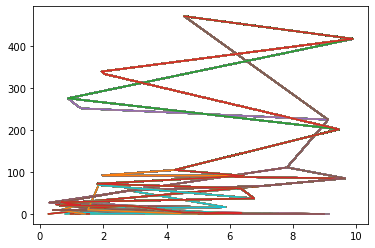

In [652]:
times = []
for node in condensed_ts.nodes():
    times.append(node.time)

locations = []
for node in condensed_ts.nodes():
    lookup_id = node.id
    if ((node.id-1) in simple_recomb_nodes):
        lookup_id = node.id-1
    original_id = node_lookup["subset_ts_id"].values[(node_lookup["simple_id"].values==lookup_id).argmax()]
    locations.append(subset_ts.tables.individuals[original_id].location[0])

for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(times[n])
        p_locs.append(locations[n])
    plt.plot(p_locs, p_times)
plt.show()

In [385]:
subset_ts.tables.individuals

id,flags,location,parents,metadata
0,327680,"8.747812915939065, 6.83945829300247, 0.0","-1, 21806","{'pedigree_id': 991370, 'pedigree_p1'..."
1,327680,"9.142955536498873, 9.85733698031757, 0.0","21818, 21820","{'pedigree_id': 991373, 'pedigree_p1'..."
2,327680,"8.897204068907817, 9.626492289057255, 0.0","21818, 21820","{'pedigree_id': 991374, 'pedigree_p1'..."
3,327680,"5.799397593954218, 1.5682437886861849, 0.0","21821, 21828","{'pedigree_id': 991375, 'pedigree_p1'..."
4,327680,"5.797625659515849, 1.7903554470277876, 0.0","21821, 21828","{'pedigree_id': 991376, 'pedigree_p1'..."
5,327680,"8.187545833139962, 2.8363180479991676, 0.0","-1, 21800","{'pedigree_id': 991377, 'pedigree_p1'..."
6,327680,"1.353952542320996, 5.38736736598481, 0.0","-1, 21819","{'pedigree_id': 991382, 'pedigree_p1'..."
7,327680,"1.2814523578898676, 6.039936121091078, 0.0","-1, 21819","{'pedigree_id': 991383, 'pedigree_p1'..."
8,327680,"5.693715629601549, 5.421214977532155, 0.0","-1, 21802","{'pedigree_id': 991384, 'pedigree_p1'..."
9,327680,"9.07458602583881, 9.994879056881889, 0.0","21823, 21818","{'pedigree_id': 991385, 'pedigree_p1'..."


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49

